# Project Title:

## Libraries and settings

In [1]:
# Load Python libraries
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Show current working directory
print(os.getcwd())

/workspaces/ARM_Gruppe-5


## Import data

In [2]:
## Read data
df = pd.read_csv("03 - EDA/Data/eda_dataset_2019_complete.csv", sep=",")
df.head()

,Year,BFS ID,Municipality,Average Rent CHF,Tax Rate Natural Persons %,Foreigners Share %,Average Household Size,Income per Taxpayer CHF
0,2019,2762,Allschwil,1386.390980,58.0,27.54,2.09,69297.680200
1,2019,2841,Anwil,1273.541876,63.0,6.06,2.44,55915.967552
2,2019,2881,Arboldswil,1297.855975,60.0,6.41,2.41,71971.136872
3,2019,2821,Arisdorf,1492.762047,59.0,11.51,2.42,70530.944063
4,2019,2763,Arlesheim,1483.157538,45.0,20.04,2.13,87560.147338


## Regression model - Quadratmeterpreis Wohnbauland / Bewohner 2022

Multiple linear Regression (3D):
Intercept: 344.48
Koeffizient Household Size: 227.8649
Koeffizient Income: 0.007711
Anzahl Beobachtungen: 58

--- Modellgüte (Nachweis) ---
R² (manuell) = 1 - SS_res/SS_tot
SS_res = Σ(y - ŷ)² = 770632.7874
SS_tot = Σ(y - ȳ)² = 1556334.5312
R² (manuell) = 0.504841
R² (sklearn) = 0.504841

RMSE (manuell) = sqrt(MSE)
MSE = Ø(y - ŷ)² = 13286.772196
RMSE = 115.268262 CHF


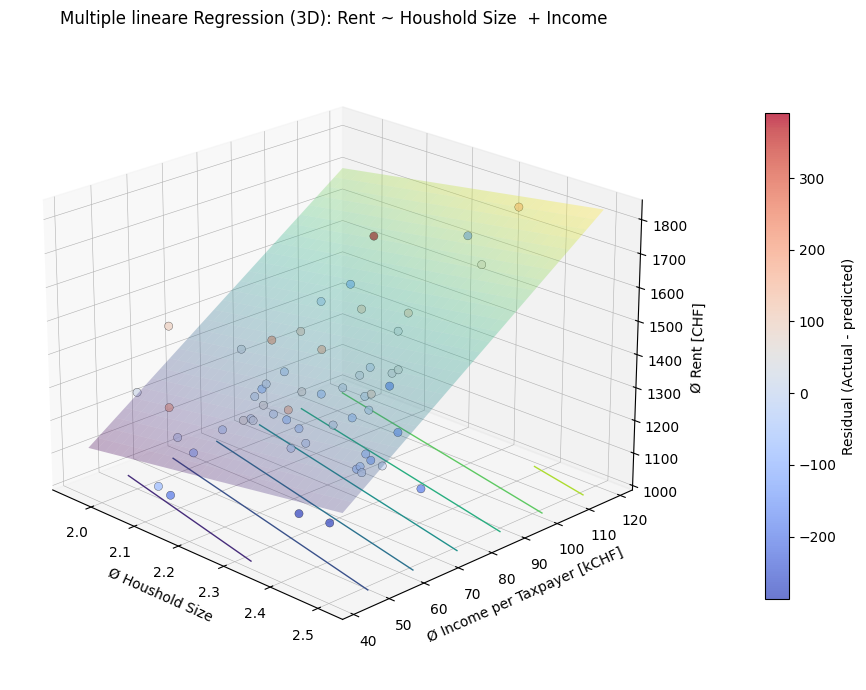

In [3]:
# Multiple lineare Regression (3D)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

# 1. Data import
file_path = "03 - EDA/Data/eda_dataset_2019_complete.csv"
df = pd.read_csv(file_path)

# 2. Select relevant columns
cols = [
    "Average Rent CHF",
    "Average Household Size",
    "Income per Taxpayer CHF"
]

df_model = df[cols].copy()

# 3. Clean data
df_model = df_model.dropna()

df_model = df_model[
    (df_model["Average Rent CHF"] != 0) &
    (df_model["Average Household Size"] != 0) &
    (df_model["Income per Taxpayer CHF"] != 0)
]

# 4. Define regression variables
X = df_model[["Average Household Size", "Income per Taxpayer CHF"]]
y = df_model["Average Rent CHF"]

# 5. Multiple linear Regression model
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

# 6. R²- und  RMSE proof (model goodness)
# R² = 1 - (SS_res / SS_tot)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2_manual = 1 - ss_res / ss_tot

# RMSE = sqrt( MSE )
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

# Zusätzlich: R² via sklearn (soll identisch zu r2_manual sein)
r2_sklearn = r2_score(y, y_pred)

print("Multiple linear Regression (3D):")
print(f"Intercept: {model.intercept_:.2f}")
print(f"Koeffizient Household Size: {model.coef_[0]:.4f}")
print(f"Koeffizient Income: {model.coef_[1]:.6f}")
print(f"Anzahl Beobachtungen: {len(df_model)}")

print("\n--- Modellgüte (Nachweis) ---")
print("R² (manuell) = 1 - SS_res/SS_tot")
print(f"SS_res = Σ(y - ŷ)² = {ss_res:.4f}")
print(f"SS_tot = Σ(y - ȳ)² = {ss_tot:.4f}")
print(f"R² (manuell) = {r2_manual:.6f}")
print(f"R² (sklearn) = {r2_sklearn:.6f}")

print("\nRMSE (manuell) = sqrt(MSE)")
print(f"MSE = Ø(y - ŷ)² = {mse:.6f}")
print(f"RMSE = {rmse:.6f} CHF")

# 7. 3D Visualization (clearer)

# Residuals for color coding
residuals = y - y_pred

# Income in kCHF only for image
income_k = df_model["Income per Taxpayer CHF"] / 1000

fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111, projection="3d")

# Scatter: Points colored by residual (over-/underestimation)
sc = ax.scatter(
    df_model["Average Household Size"],
    income_k,
    y,
    c=residuals,
    cmap="coolwarm",
    s=35,
    alpha=0.75,
    edgecolor="k",
    linewidth=0.25
)

cbar = plt.colorbar(sc, ax=ax, pad=0.10, shrink=0.75)
cbar.set_label("Residual (Actual - predicted)")

# Regressionsfläche (auf Achsenskalierung kCHF angepasst)
x_surf, income_k_surf = np.meshgrid(
    np.linspace(df_model["Average Household Size"].min(),
                df_model["Average Household Size"].max(), 30),
    np.linspace(income_k.min(),
                income_k.max(), 30)
)

# Correction CHF and kCHF
y_surf = (
    model.intercept_
    + model.coef_[0] * x_surf
    + model.coef_[1] * (income_k_surf * 1000)
)

ax.plot_surface(
    x_surf,
    income_k_surf,
    y_surf,
    cmap="viridis",
    alpha=0.30,
    linewidth=0,
    antialiased=True
)

# ground projection
z_offset = y.min() - (y.max() - y.min()) * 0.02
ax.contour(
    x_surf,
    income_k_surf,
    y_surf,
    zdir="z",
    offset=z_offset,
    cmap="viridis",
    linewidths=1
)

# Labels
ax.set_xlabel("Ø Houshold Size")
ax.set_ylabel("Ø Income per Taxpayer [kCHF]")
ax.set_zlabel("Ø Rent [CHF]")
ax.set_title("Multiple lineare Regression (3D): Rent ~ Houshold Size  + Income")

# Format
ax.set_zlim(z_offset, y.max())
ax.ticklabel_format(style="plain", axis="y")  # keine wissenschaftliche Notation

# Viewpoint (correction for better visibility)
ax.view_init(elev=22, azim=-45)

# decent grid lines
ax.xaxis._axinfo["grid"]["linewidth"] = 0.4
ax.yaxis._axinfo["grid"]["linewidth"] = 0.4
ax.zaxis._axinfo["grid"]["linewidth"] = 0.4

plt.tight_layout()
plt.show()


--- p-values (statsmodels OLS) ---
                               coef     std_err         t       p_value
const                    344.481376  275.028495  1.252530  2.156766e-01
Average Household Size   227.864871  119.450605  1.907608  6.166871e-02
Income per Taxpayer CHF    0.007711    0.001102  6.995940  3.830280e-09

P-values:
Intercept (const): 0.215677
Household Size:    0.0616687
Income:            3.83028e-09

F-test p-value (overall model): 4.03157e-09

--- Chi-squared test: Breusch–Pagan (heteroskedasticity) ---
LM statistic (chi2): 0.5527
LM p-value:          0.758563
F statistic:         0.2646
F p-value:           0.768517
Multiple linear Regression (3D):
Intercept: 344.48
Koeffizient Household Size: 227.8649
Koeffizient Income: 0.007711
Anzahl Beobachtungen: 58

--- Modellgüte (Nachweis) ---
R² (manuell) = 1 - SS_res/SS_tot
SS_res = Σ(y - ŷ)² = 770632.7874
SS_tot = Σ(y - ȳ)² = 1556334.5312
R² (manuell) = 0.504841
R² (sklearn) = 0.504841

RMSE (manuell) = sqrt(MSE)
MSE =

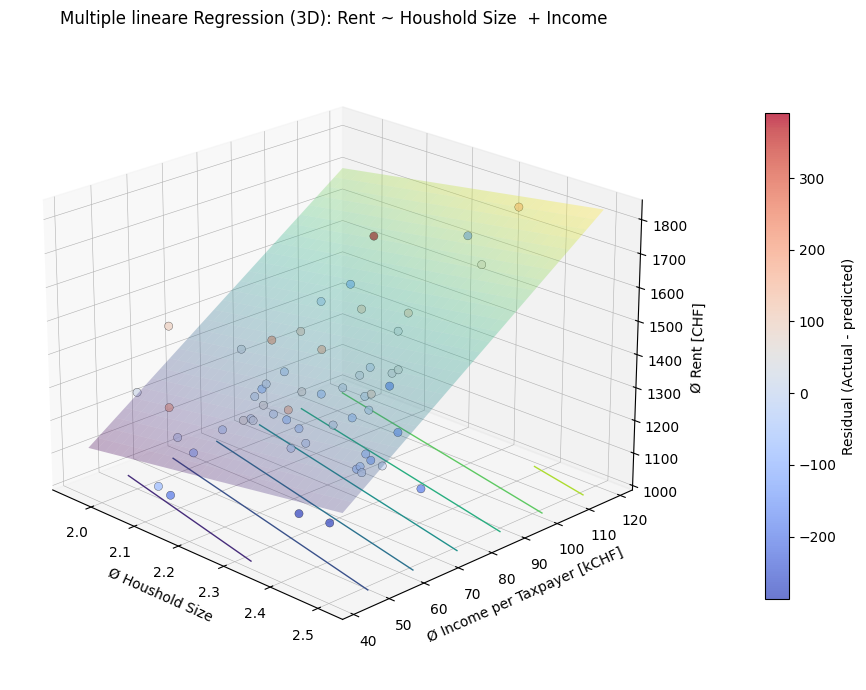

In [15]:
# Multiple lineare Regression (3D)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.diagnostic import het_breuschpagan

ols = sm.OLS(y, X_sm).fit()

# 1. Data import
file_path = "03 - EDA/Data/eda_dataset_2019_complete.csv"
df = pd.read_csv(file_path)

# 2. Select relevant columns
cols = [
    "Average Rent CHF",
    "Average Household Size",
    "Income per Taxpayer CHF"
]

df_model = df[cols].copy()

# 3. Clean data
df_model = df_model.dropna()

df_model = df_model[
    (df_model["Average Rent CHF"] != 0) &
    (df_model["Average Household Size"] != 0) &
    (df_model["Income per Taxpayer CHF"] != 0)
]

# 4. Define regression variables
X = df_model[["Average Household Size", "Income per Taxpayer CHF"]]
y = df_model["Average Rent CHF"]

# 5. Multiple linear Regression model
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

# 5b. p-values (via statsmodels OLS)
# Note: p-values are based on classical OLS assumptions (linearity, i.i.d. errors, homoscedasticity, etc.)
X_sm = sm.add_constant(X)          # adds intercept column "const"
ols = sm.OLS(y, X_sm).fit()

# formatted coefficient table (coef, std err, t, p-value)
coef_table = pd.DataFrame({
    "coef": ols.params,
    "std_err": ols.bse,
    "t": ols.tvalues,
    "p_value": ols.pvalues
})
print("\n--- p-values (statsmodels OLS) ---")
print(coef_table)

# single p-values explicitly:
print("\nP-values:")
print(f"Intercept (const): {ols.pvalues['const']:.6g}")
print(f"Household Size:    {ols.pvalues['Average Household Size']:.6g}")
print(f"Income:            {ols.pvalues['Income per Taxpayer CHF']:.6g}")

# Optional: overall model significance (F-test)
print(f"\nF-test p-value (overall model): {ols.f_pvalue:.6g}")

# 5c. Chi-squared test (Breusch–Pagan) for heteroskedasticity
# H0: homoskedastic residuals (constant variance)
bp_lm, bp_lm_pvalue, bp_f, bp_f_pvalue = het_breuschpagan(ols.resid, ols.model.exog)

print("\n--- Chi-squared test: Breusch–Pagan (heteroskedasticity) ---")
print(f"LM statistic (chi2): {bp_lm:.4f}")
print(f"LM p-value:          {bp_lm_pvalue:.6g}")
print(f"F statistic:         {bp_f:.4f}")
print(f"F p-value:           {bp_f_pvalue:.6g}")

# 6. R²- und  RMSE proof (model goodness)
# R² = 1 - (SS_res / SS_tot)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2_manual = 1 - ss_res / ss_tot

# RMSE = sqrt( MSE )
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

# Zusätzlich: R² via sklearn (soll identisch zu r2_manual sein)
r2_sklearn = r2_score(y, y_pred)

print("Multiple linear Regression (3D):")
print(f"Intercept: {model.intercept_:.2f}")
print(f"Koeffizient Household Size: {model.coef_[0]:.4f}")
print(f"Koeffizient Income: {model.coef_[1]:.6f}")
print(f"Anzahl Beobachtungen: {len(df_model)}")

print("\n--- Modellgüte (Nachweis) ---")
print("R² (manuell) = 1 - SS_res/SS_tot")
print(f"SS_res = Σ(y - ŷ)² = {ss_res:.4f}")
print(f"SS_tot = Σ(y - ȳ)² = {ss_tot:.4f}")
print(f"R² (manuell) = {r2_manual:.6f}")
print(f"R² (sklearn) = {r2_sklearn:.6f}")

print("\nRMSE (manuell) = sqrt(MSE)")
print(f"MSE = Ø(y - ŷ)² = {mse:.6f}")
print(f"RMSE = {rmse:.6f} CHF")

# 7. 3D Visualization (clearer)

# Residuals for color coding
residuals = y - y_pred

# Income in kCHF only for image
income_k = df_model["Income per Taxpayer CHF"] / 1000

fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111, projection="3d")

# Scatter: Points colored by residual (over-/underestimation)
sc = ax.scatter(
    df_model["Average Household Size"],
    income_k,
    y,
    c=residuals,
    cmap="coolwarm",
    s=35,
    alpha=0.75,
    edgecolor="k",
    linewidth=0.25
)

cbar = plt.colorbar(sc, ax=ax, pad=0.10, shrink=0.75)
cbar.set_label("Residual (Actual - predicted)")

# Regressionsfläche (auf Achsenskalierung kCHF angepasst)
x_surf, income_k_surf = np.meshgrid(
    np.linspace(df_model["Average Household Size"].min(),
                df_model["Average Household Size"].max(), 30),
    np.linspace(income_k.min(),
                income_k.max(), 30)
)

# Correction CHF and kCHF
y_surf = (
    model.intercept_
    + model.coef_[0] * x_surf
    + model.coef_[1] * (income_k_surf * 1000)
)

ax.plot_surface(
    x_surf,
    income_k_surf,
    y_surf,
    cmap="viridis",
    alpha=0.30,
    linewidth=0,
    antialiased=True
)

# ground projection
z_offset = y.min() - (y.max() - y.min()) * 0.02
ax.contour(
    x_surf,
    income_k_surf,
    y_surf,
    zdir="z",
    offset=z_offset,
    cmap="viridis",
    linewidths=1
)

# Labels
ax.set_xlabel("Ø Houshold Size")
ax.set_ylabel("Ø Income per Taxpayer [kCHF]")
ax.set_zlabel("Ø Rent [CHF]")
ax.set_title("Multiple lineare Regression (3D): Rent ~ Houshold Size  + Income")

# Format
ax.set_zlim(z_offset, y.max())
ax.ticklabel_format(style="plain", axis="y")  # keine wissenschaftliche Notation

# Viewpoint (correction for better visibility)
ax.view_init(elev=22, azim=-45)

# decent grid lines
ax.xaxis._axinfo["grid"]["linewidth"] = 0.4
ax.yaxis._axinfo["grid"]["linewidth"] = 0.4
ax.zaxis._axinfo["grid"]["linewidth"] = 0.4

plt.tight_layout()
plt.show()

=== Baseline Decision Tree ===
RMSE (test): 142.29 CHF
R²   (test): -4.282

=== Tuned Decision Tree (GridSearchCV) ===
Best Params: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}
CV RMSE (best): 132.88 CHF
RMSE (test):    111.58 CHF
R²   (test):    -2.248

=== Feature Importances (Tree) ===
Income per Taxpayer CHF       0.740200
Foreigners Share %            0.165579
Average Household Size        0.094221
Tax Rate Natural Persons %    0.000000



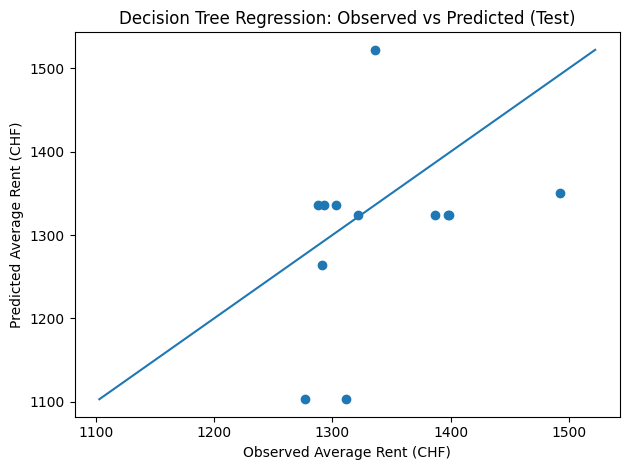

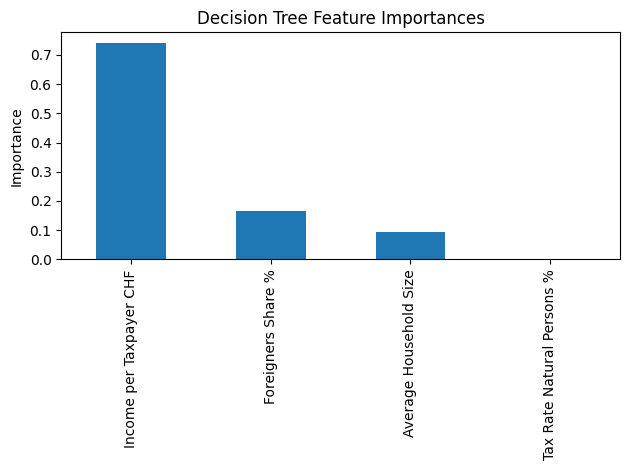

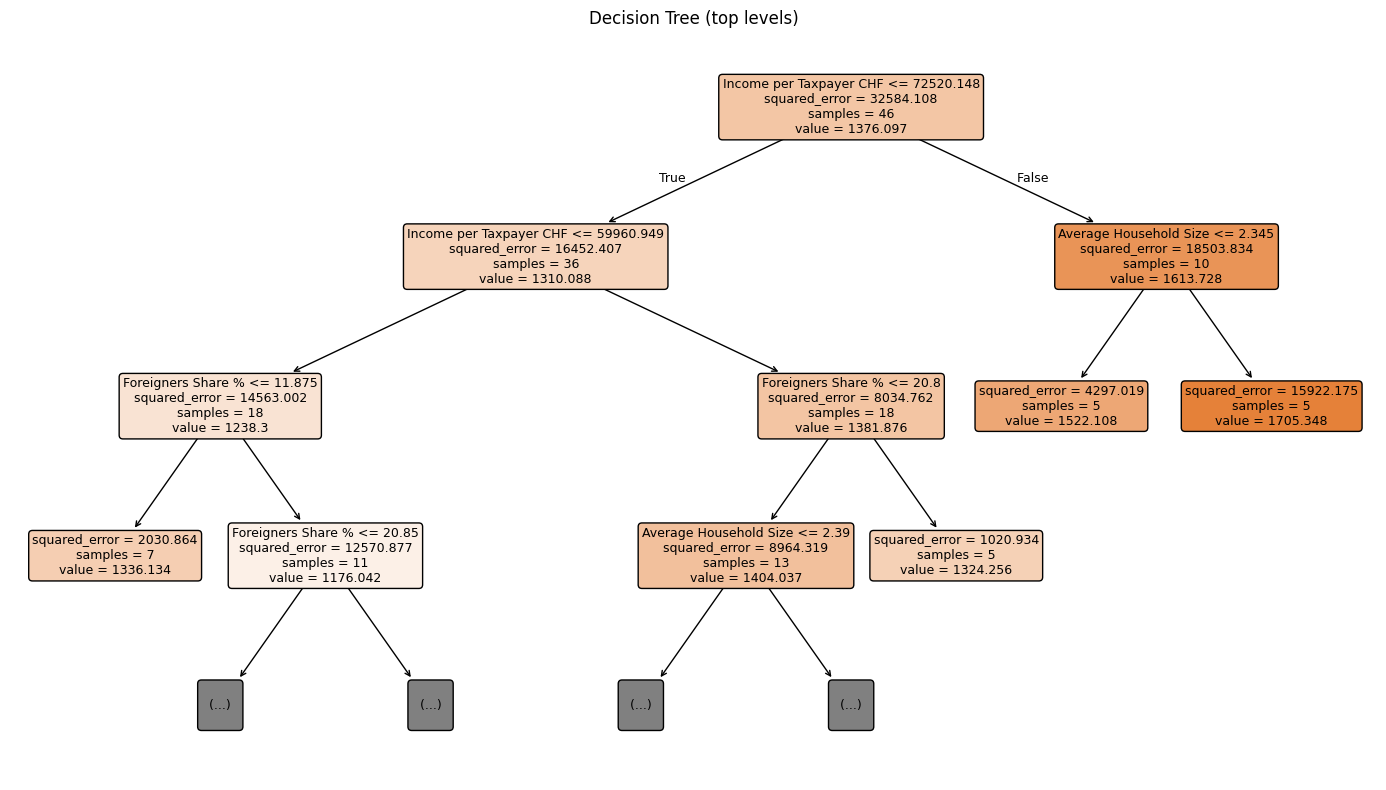

In [10]:
# regression_tree.py
# Regression Tree (DecisionTreeRegressor) für Gemeinde-Mietpreise (Basel-Land / 2019 Dataset)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def main():
    # 1) Daten laden
    DATA_PATH = "03 - EDA/Data/eda_dataset_2019_complete.csv"  # ggf. anpassen
    df = pd.read_csv(DATA_PATH)

    # Optional: nur Jahr 2019 behalten (falls andere Jahre drin wären)
    if "Year" in df.columns:
        df = df[df["Year"] == 2019].copy()

    # 2) Zielvariable & Features definieren (analog MLR: nur sinnvolle numerische Prädiktoren)
    target_col = "Average Rent CHF"
    feature_cols = [
        "Tax Rate Natural Persons %",
        "Foreigners Share %",
        "Average Household Size",
        "Income per Taxpayer CHF",
    ]

    # Defensive Checks
    missing_cols = [c for c in [target_col, *feature_cols] if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Spalten fehlen im Datensatz: {missing_cols}")

    # 3) Minimal Cleaning: nur die Spalten, die wir brauchen, und fehlende Werte entfernen
    model_df = df[[target_col] + feature_cols].dropna().copy()

    X = model_df[feature_cols]
    y = model_df[target_col]

    # 4) Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 5) Baseline Tree (ohne Tuning)
    base_model = DecisionTreeRegressor(random_state=42)
    base_model.fit(X_train, y_train)

    y_pred_base = base_model.predict(X_test)
    base_rmse = rmse(y_test, y_pred_base)
    base_r2 = r2_score(y_test, y_pred_base)

    print("=== Baseline Decision Tree ===")
    print(f"RMSE (test): {base_rmse:,.2f} CHF")
    print(f"R²   (test): {base_r2:,.3f}")
    print()


    # 6) Hyperparameter-Tuning (GridSearchCV)
    param_grid = {
        "max_depth": [2, 3, 4, 5, None],
        "min_samples_split": [2, 4, 6, 10],
        "min_samples_leaf": [1, 2, 3, 5],
    }

    tree = DecisionTreeRegressor(random_state=42)
    grid = GridSearchCV(
        estimator=tree,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",  # direkt RMSE optimieren
        cv=5,
        n_jobs=-1,
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    tuned_rmse = rmse(y_test, y_pred)
    tuned_r2 = r2_score(y_test, y_pred)

    print("=== Tuned Decision Tree (GridSearchCV) ===")
    print(f"Best Params: {grid.best_params_}")
    print(f"CV RMSE (best): {-grid.best_score_:,.2f} CHF")
    print(f"RMSE (test):    {tuned_rmse:,.2f} CHF")
    print(f"R²   (test):    {tuned_r2:,.3f}")
    print()

    # 7) Feature Importance
    importances = pd.Series(best_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("=== Feature Importances (Tree) ===")
    print(importances.to_string())
    print()

    # 8) Plots: y_true vs y_pred
    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Observed Average Rent (CHF)")
    plt.ylabel("Predicted Average Rent (CHF)")
    plt.title("Decision Tree Regression: Observed vs Predicted (Test)")
    # Diagonale als Orientierung
    minv = min(y_test.min(), y_pred.min())
    maxv = max(y_test.max(), y_pred.max())
    plt.plot([minv, maxv], [minv, maxv])
    plt.tight_layout()
    plt.show()

    # 9) Plot: Feature Importances
    plt.figure()
    importances.plot(kind="bar")
    plt.ylabel("Importance")
    plt.title("Decision Tree Feature Importances")
    plt.tight_layout()
    plt.show()

    # 10) Plot: Tree (bei großen Trees wird das unübersichtlich -> max_depth begrenzen)
    plt.figure(figsize=(14, 8))
    plot_tree(
        best_model,
        feature_names=feature_cols,
        filled=True,
        rounded=True,
        max_depth=3,  # nur die obersten Levels anzeigen
        fontsize=9,
    )
    plt.title("Decision Tree (top levels)")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

Rows: 58
   Average Rent CHF  Tax Rate Natural Persons %  Income per Taxpayer CHF
0       1386.390980                        58.0             69297.680200
1       1273.541876                        63.0             55915.967552
2       1297.855975                        60.0             71971.136872
3       1492.762047                        59.0             70530.944063
4       1483.157538                        45.0             87560.147338

Pearson correlation matrix:
                            Average Rent CHF  Tax Rate Natural Persons %  \
Average Rent CHF                    1.000000                   -0.587410   
Tax Rate Natural Persons %         -0.587410                    1.000000   
Income per Taxpayer CHF             0.687081                   -0.762935   

                            Income per Taxpayer CHF  
Average Rent CHF                           0.687081  
Tax Rate Natural Persons %                -0.762935  
Income per Taxpayer CHF                    1.000000  

Sp

Best parameters: {'max_depth': 2, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 800}
Best CV R² (on TRAIN folds): 0.3288096377916664

Random Forest performance (holdout split)
Train R² : 0.604404436979777
Train RMSE: 113.5347016343112
Test  R² : -0.9494599631708482
Test  RMSE: 86.44706143143391

5-fold Cross-Validation
R²  mean: 0.04331305322487968  | std: 0.4908339242853495
RMSE mean: 127.92000779476018  | std: 29.404325059511006

Feature importances:
Income per Taxpayer CHF       0.921386
Tax Rate Natural Persons %    0.078614
dtype: float64


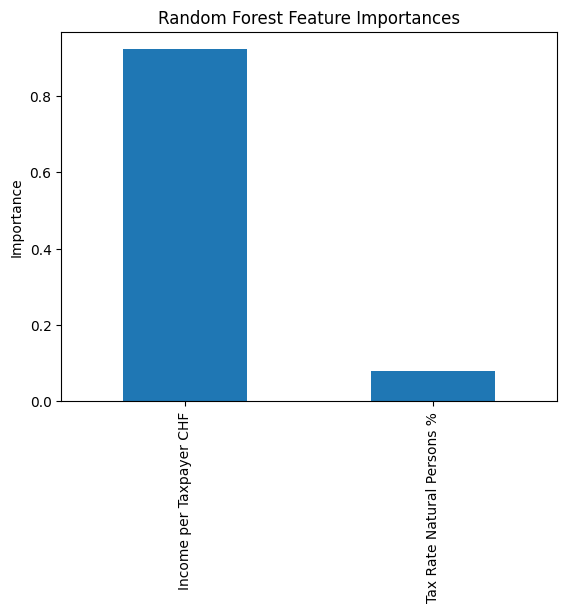

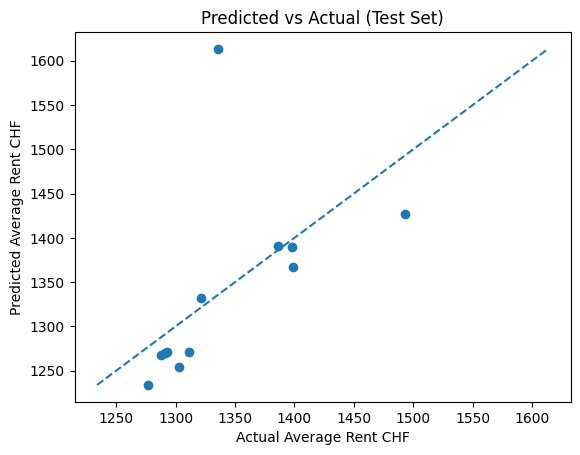

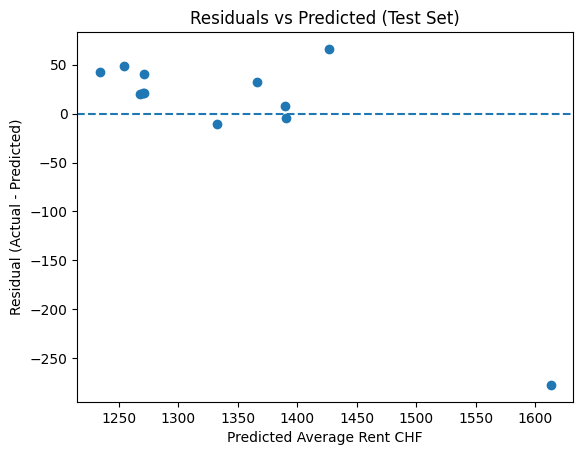

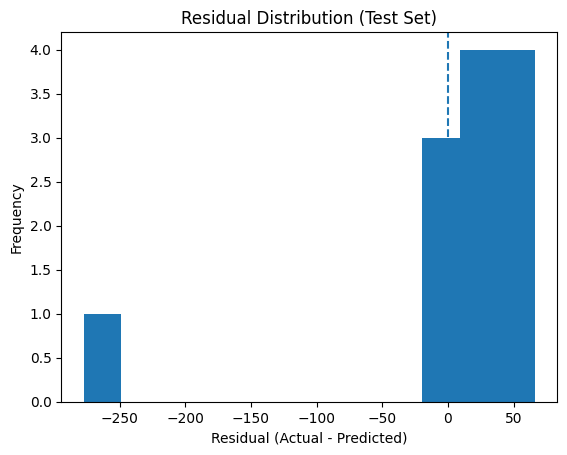

In [6]:
# %% [markdown]
# # Random Forest Regression: Predicting Average Rent (CHF)
#
# **Target:** Average Rent CHF  
# **Features:** Tax Rate Natural Persons %, Income per Taxpayer CHF  
#
# This notebook:
# 1) Loads the dataset  
# 2) Computes correlations  
# 3) Trains a Random Forest regression model (with optional hyperparameter search)  
# 4) Evaluates performance using R² and RMSE (holdout + cross-validation)  
# 5) Visualizes predictions and residuals  

# %%
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt


# %% [markdown]
# ## 1) Load data

# %%
DATA_PATH = "03 - EDA/Data/eda_dataset_2019_complete.csv"

df = pd.read_csv(DATA_PATH)

TARGET = "Average Rent CHF"
FEATURES = ["Tax Rate Natural Persons %", "Income per Taxpayer CHF"]

# Basic checks
missing_cols = [c for c in [TARGET] + FEATURES if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataset: {missing_cols}")

df_model = df[[TARGET] + FEATURES].copy()

print("Rows:", len(df_model))
print(df_model.head())


# %% [markdown]
# ## 2) Correlations (Pearson & Spearman)

# %%
pearson_corr = df_model.corr(method="pearson")
spearman_corr = df_model.corr(method="spearman")

print("\nPearson correlation matrix:")
print(pearson_corr)

print("\nSpearman correlation matrix:")
print(spearman_corr)

print("\nCorrelations with target (Pearson):")
print(pearson_corr[TARGET].sort_values(ascending=False))

print("\nCorrelations with target (Spearman):")
print(spearman_corr[TARGET].sort_values(ascending=False))


# %% [markdown]
# ## 3) Train/Test split

# %%
X = df_model[FEATURES]
y = df_model[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))


# %% [markdown]
# ## 4) Metrics helpers (RMSE, compatible across sklearn versions)

# %%
def rmse(y_true, y_pred):
    """
    Root Mean Squared Error.
    Uses sklearn.metrics.root_mean_squared_error if available,
    otherwise computes it manually.
    """
    try:
        from sklearn.metrics import root_mean_squared_error
        return root_mean_squared_error(y_true, y_pred)
    except Exception:
        return float(np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2)))


# %% [markdown]
# ## 5) Baseline model (predict mean) for reference

# %%
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

y_pred_base_train = baseline.predict(X_train)
y_pred_base_test = baseline.predict(X_test)

print("\nBaseline (DummyRegressor: mean) performance")
print("Train R² :", r2_score(y_train, y_pred_base_train))
print("Train RMSE:", rmse(y_train, y_pred_base_train))
print("Test  R² :", r2_score(y_test, y_pred_base_test))
print("Test  RMSE:", rmse(y_test, y_pred_base_test))


# %% [markdown]
# ## 6) Random Forest Regression (with optional GridSearchCV)
#
# Notes:
# - Dataset is small, so results can vary a lot depending on the holdout split.
# - Cross-validation is often more informative than a single train/test split.

# %%
use_grid_search = True  # set False if you want fixed hyperparameters

if use_grid_search:
    rf = RandomForestRegressor(random_state=42)

    param_grid = {
        "n_estimators": [300, 500, 800],
        "max_depth": [None, 2, 3, 4, 6],
        "min_samples_leaf": [1, 2, 4],
        "min_samples_split": [2, 4, 8],
        "max_features": ["sqrt", 1.0],  # 1.0 = use all features
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring="r2",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)

    model = grid.best_estimator_
    print("Best parameters:", grid.best_params_)
    print("Best CV R² (on TRAIN folds):", grid.best_score_)

else:
    model = RandomForestRegressor(
        n_estimators=500,
        max_depth=3,
        min_samples_leaf=2,
        random_state=42
    )
    model.fit(X_train, y_train)


# %% [markdown]
# ## 7) Holdout evaluation (R², RMSE)

# %%
# Fit (in case grid search is off, already fitted; refit doesn't hurt)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_rmse = rmse(y_train, y_pred_train)
test_rmse = rmse(y_test, y_pred_test)

print("\nRandom Forest performance (holdout split)")
print("Train R² :", train_r2)
print("Train RMSE:", train_rmse)
print("Test  R² :", test_r2)
print("Test  RMSE:", test_rmse)


# %% [markdown]
# ## 8) Cross-validation (more robust than a single split)

# %%
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# R²
cv_r2 = cross_val_score(model, X, y, scoring="r2", cv=cv, n_jobs=-1)

# RMSE (negative by convention in sklearn)
cv_neg_rmse = cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
cv_rmse = -cv_neg_rmse

print("\n5-fold Cross-Validation")
print("R²  mean:", cv_r2.mean(), " | std:", cv_r2.std())
print("RMSE mean:", cv_rmse.mean(), " | std:", cv_rmse.std())


# %% [markdown]
# ## 9) Feature importances

# %%
importances = pd.Series(model.feature_importances_, index=FEATURES).sort_values(ascending=False)
print("\nFeature importances:")
print(importances)

importances.plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.show()


# %% [markdown]
# ## 10) Diagnostics plots (Predicted vs Actual, Residuals)

# %%
# Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual Average Rent CHF")
plt.ylabel("Predicted Average Rent CHF")
plt.title("Predicted vs Actual (Test Set)")

# 45-degree reference line (robust across matplotlib versions)
min_v = min(y_test.min(), y_pred_test.min())
max_v = max(y_test.max(), y_pred_test.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")

plt.show()

# Residuals vs Predicted
residuals = y_test - y_pred_test

plt.figure()
plt.scatter(y_pred_test, residuals)
plt.xlabel("Predicted Average Rent CHF")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Test Set)")
plt.axhline(0, linestyle="--")
plt.show()

# Optional: Residual distribution (helps detect skew / outliers)
plt.figure()
plt.hist(residuals, bins=12)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Test Set)")
plt.axvline(0, linestyle="--")
plt.show()